## Import Libaraies

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as pl
import numpy as np
import warnings
import os
warnings.filterwarnings("ignore")

# Define Functions

In [2]:
target = 'DollarsPerMegawattHour'
boolean_dict = {'Y':1, 'N':0}
island_dict = {'NI':1, 'SI':0}

def read_energy_csv(filename, PoC = None):
  df = pd.read_csv(filename)
  if PoC != None:
    df = df[df['PointOfConnection'] == PoC]
    df = df.drop(columns = ['PointOfConnection'])
  df['DateTime'] = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S.000%z") for date in df['PublishDateTime']]
  df['IsProxyPriceFlag'] = [boolean_dict[c] for c in df['IsProxyPriceFlag']]
  # df = df.drop(columns = ['Island']) #'TradingDate',
  df['Date'] = [p.date() for p in df['DateTime']]
  df['Time'] = [p.time() for p in df['DateTime']]
  df['IntTime'] = [t.hour*3600+t.minute*60+t.second for t in df['Time']]
  df['Year'] = [d.year for d in df['Date']]
  df['Month'] = [d.month for d in df['Date']]
  df['Day'] = [d.day for d in df['Date']]
  df = df.drop(columns = ['Island', 'Date', 'Time'])
  return df

def num_string(x, length = 2):
  string = str(x)
  while len(string) < length:
    string = "0"+string
  return string

def date_string(day, month, year, length = 2):
  return (num_string(year,length)+
          num_string(month,length)+
          num_string(day,length))

def make_url(day, month, year = 2023):
  year_string = date_string(day, month, year)
  s = "https://www.emi.ea.govt.nz/Wholesale/Datasets/DispatchAndPricing/DispatchEnergyPrices/"
  s = s+str(year)+"/"+year_string+"_DispatchEnergyPrices.csv"
  return s

seconds_in_a_day = 86400
def cyclic_encoder(x, min = 0, max = seconds_in_a_day):
  lambd = [2*np.pi*(n-min)/(max-min) for n in x]
  sin_x = [np.sin(n) for n in lambd]
  cos_x = [np.cos(n) for n in lambd]
  return (sin_x, cos_x)

def csv_to_arff(csv_file_path, arff_file_path, relation_name='relation'):
    
    df = pd.read_csv(csv_file_path)

    # Open the ARFF file for writing
    with open(arff_file_path, 'w') as f:
        # Write the relation name
        f.write(f"@relation {relation_name}\n\n")
        
        # Write attribute names and types
        for col in df.columns:
            if df[col].dtype == 'object':
                f.write(f"@attribute {col} nominal\n")
            elif df[col].dtype == 'int64':
                f.write(f"@attribute {col} numeric\n")
            elif df[col].dtype == 'float64':
                f.write(f"@attribute {col} numeric\n")
            else:
                f.write(f"@attribute {col} unknown\n")

        f.write("\n@data\n")

        # Write the data
        for index, row in df.iterrows():
            f.write(','.join(map(str, row.values)) + '\n')

def make_targets_with_delay(dict, delay: int = 1, target='Avg$PerMWHr'):
    not_target = 'Med$PerMWHr' if target == 'Avg$PerMWHr' else 'Avg$PerMWHr'
    target_col = dict['Avg$PerMWHr']
    previous_tar_str = 'Prev'+target
    previous_not_tar_str = 'Prev'+not_target
    targets = dict[target]
    previous_col = list(dict[previous_tar_str])
    previous_other_col = list(dict[previous_not_tar_str])
    for i in range(delay -1):
        previous_col.insert(0,0)
        previous_col.pop()
        previous_other_col.insert(0,0)
        previous_other_col.pop()
    df = dict.drop(columns=target)
    df = dict.drop(columns=not_target)
    df[target] = targets
    df[previous_tar_str] = previous_col
    df[previous_not_tar_str] = previous_other_col

    # re-order the columns to put the target at the end
    column_to_move = target
    cols = [col for col in df.columns if col != column_to_move]
    re_ordered = cols + [column_to_move]
    df = df[re_ordered]
    
    df = df.iloc[delay - 1:]

    return df

# Specify Date Range

In [3]:
month_date_dict = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
                   7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# first available date
dates = [(1, 11, 2022)]

# specify the last day
# be careful with the current date, since it might not be fully available yet
last_day = (30, 4, 2024)

while dates[-1] != last_day:
  last_date = dates[-1]
  date = (last_date[0]+1, last_date[1], last_date[2])
  if date[0] > month_date_dict[date[1]]:
    date = (1, date[1]+1, date[2])
  if date[1] > 12:
    date = (1, 1, date[2]+1)
  dates.append(date)

# Specify Point of Connection

### Available Options
* 'ABY0111' 'ALB0331' 'ALB1101' 'APS0111' 'ARA2201' 'ARG1101' 'ARI1101'
'ARI1102' 'ASB0661' 'ASY0111' 'ATI2201' 'AVI2201' 'BAL0331' 'BDE0111'
'BEN2201' 'BEN2202' 'BLN0331' 'BOB1101' 'BPD1101' 'BPE0331' 'BPE0551'
'BPE2201' 'BPT1101' 'BRB0331' 'BRK0331' 'BRY0661' 'BWK1101' 'CBG0111'
'CLH0111' 'CML0331' 'COL0111' 'COL0661' 'CPK0111' 'CPK0331' 'CST0331'
'CUL0331' 'CUL0661' 'CYD0331' 'CYD2201' 'DOB0331' 'DOB0661' 'DVK0111'
'EDG0331' 'EDN0331' 'FHL0331' 'FKN0331' 'GFD0331' 'GLN0331' 'GLN0332'
'GOR0331' 'GYM0661' 'GYT0331' 'HAM0111' 'HAM0331' 'HAM0551' 'HAM2201'
'HAY0111' 'HAY0331' 'HAY1101' 'HAY2201' 'HEN0331' 'HEN2201' 'HEP0331'
'HIN0331' 'HKK0661' 'HLY0331' 'HLY2201' 'HOB1101' 'HOR0331' 'HOR0661'
'HRP2201' 'HTI0331' 'HTI1101' 'HUI0331' 'HWA0331' 'HWA0332' 'HWA1101'
'HWA1102' 'HWB0331' 'HWB1101' 'HWB2201' 'INV0331' 'INV2201' 'INV2202'
'ISL0331' 'ISL0661' 'ISL2201' 'JRD1101' 'KAI0111' 'KAW0111' 'KAW0112'
'KAW1101' 'KAW2201' 'KBY0661' 'KBY0662' 'KIK0111' 'KIK2201' 'KIN0111'
'KIN0112' 'KIN0113' 'KIN0331' 'KMO0331' 'KOE1101' 'KPA1101' 'KPO1101'
'KPU0661' 'KUM0661' 'KWA0111' 'LFD1101' 'LFD1102' 'LTN0331' 'LTN2201'
'MAN2201' 'MAT1101' 'MCH0111' 'MDN1101' 'MDN2201' 'MGM0331' 'MHO0331'
'MKE1101' 'MLG0111' 'MLG0331' 'MNG0331' 'MNG1101' 'MNI0111' 'MPE1101'
'MST0331' 'MTI2201' 'MTM0331' 'MTN0331' 'MTO0331' 'MTR0331' 'NAP2201'
'NAP2202' 'NMA0331' 'NPK0331' 'NSY0331' 'NWD0661' 'OAM0331' 'OHA2201'
'OHB2201' 'OHC2201' 'OHK2201' 'OKI2201' 'OKN0111' 'ONG0331' 'OPK0331'
'ORO1101' 'ORO1102' 'OTA0221' 'OTA2201' 'OTI0111' 'OWH0111' 'PAK0331'
'PAO1101' 'PEN0221' 'PEN0251' 'PEN0331' 'PEN1101' 'PNI0331' 'PPI2201'
'PRM0331' 'RDF0331' 'RDF2201' 'RFN1101' 'RFN1102' 'ROS0221' 'ROS1101'
'ROT0111' 'ROT0331' 'ROT1101' 'ROX1101' 'ROX2201' 'RPO2201' 'SBK0661'
'SDN0331' 'SFD0331' 'SFD2201' 'STK0331' 'STK0661' 'STK2201' 'STU0111'
'SVL0331' 'SWN0251' 'SWN2201' 'TAB2201' 'TAK0331' 'TGA0111' 'TGA0331'
'THI2201' 'TIM0111' 'TKA0111' 'TKA0331' 'TKB2201' 'TKR0331' 'TKU0331'
'TKU2201' 'TMI0331' 'TMK0331' 'TMN0551' 'TMU0111' 'TMU1101' 'TNG0111'
'TNG0551' 'TRK0111' 'TRK2201' 'TUI1101' 'TWC2201' 'TWH0331' 'TWI2201'
'TWZ0331' 'UHT0331' 'WAI0111' 'WAI0501' 'WDV0111' 'WDV1101' 'WEL0331'
'WGN0331' 'WHI0111' 'WHI2201' 'WHU0331' 'WIL0331' 'WIR0331' 'WKM2201'
'WKO0331' 'WPA2201' 'WPR0331' 'WPR0661' 'WPW0331' 'WRD0331' 'WRK0331'
'WRK2201' 'WTK0111' 'WTK0331' 'WTK2201' 'WTU0331' 'WVY0111' 'WVY1101'
'WWD1102' 'WWD1103'

In [4]:
# Downloading may take a while
dfs = []
poc = 'WGN0331'
for day, month, year in dates:
  url = make_url(day, month, year)
  df = read_energy_csv(url, PoC = poc)
  dfs.append(df)

dfs_loaded = [df.copy() for df in dfs]
dfs_transformed = []

# Save Full Data for Further Use

In [5]:
for df in dfs:
  df_t = df.copy()
  avg = df_t.groupby(["TradingPeriod"]).mean(numeric_only=True)['DollarsPerMegawattHour']
  df_t = df_t.groupby(["TradingPeriod"]).median(numeric_only=True)
  df_t['Avg$PerMWHr'] = avg
  dfs_transformed.append(df_t)

full_data = pd.concat(dfs_transformed)
full_data.columns = full_data.columns.str.replace('DollarsPerMegawattHour',
                                                  'Med$PerMWHr')

avgs = [a for a in full_data['Avg$PerMWHr']]
meds = [m for m in full_data['Med$PerMWHr']]
avgs.insert(0, avgs[0])
avgs.pop()
meds.insert(0, meds[0])
meds.pop()
full_data['PrevAvg$PerMWHr'] = avgs
full_data['PrevMed$PerMWHr'] = meds

full_data = full_data.drop(columns = 'IntTime')
full_data['SinPeriod'], full_data['CosPeriod'] = cyclic_encoder(full_data.index, max = 48)
date_col = []
for day, month, period in zip(full_data['Day'], full_data['Month'], full_data.index):
  value = day + (period-1)/48
  for m in range(1, int(month)):
    value += month_date_dict[m]
  date_col.append(value)
full_data['SinDate'], full_data['CosDate'] = cyclic_encoder(date_col, max = 365)

for column in full_data.columns:
  full_data[column] = [round(d, 8) for d in full_data[column]]

filename = "all_"+poc+"_data.csv"

if not os.path.exists('./full_data'):
    os.makedirs('./full_data')

full_data.to_csv('./full_data/'+filename)

# Make Datasets from the Full Data

### Specify the Target
* Options: 'Avg\\$PerMWHr' or 'Med\\$PerMWHr' 

In [6]:
target = ['Avg$PerMWHr', 'Med$PerMWHr']

### Specify the Delay (each unit is 30 mins)

In [7]:
delay = [1,  ## 30 mins delay
         8,  ## 4 hrs delay
         12,  ## 6 hrs delay
         48,  ## 24 hrs delay
        ]

### Generate Datasets (CSV and ARFF)

In [9]:
# set to True if ARFF files are required
arff_option = True

if not os.path.exists('./datasets'):
    os.makedirs('./datasets')

for t in target:
    for d in delay:
        if not os.path.exists(f'./datasets/{poc}'):
            os.makedirs(f'./datasets/{poc}')
        delay_in_hour = f"{(d/2):.0f}" if (d/2).is_integer() else f"{(d/2):.1f}"
        df = make_targets_with_delay(pd.read_csv('./full_data/all_WGN0331_data.csv'), delay=d, target=t)
        df.to_csv(
            f'./datasets/{poc}/{poc}_{t[:3].lower()}_{delay_in_hour}hr.csv', index=False
        )
        if arff_option:
            csv_to_arff(
                f'./datasets/{poc}/{poc}_{t[:3].lower()}_{delay_in_hour}hr.csv', 
                f'./datasets/{poc}/{poc}_{t[:3].lower()}_{delay_in_hour}hr.arff', 
                relation_name=f'relation: PoC: {poc}; Target: {t}; Delay: {delay_in_hour}hr'
            )


# Elementary Experimental with CapyMOA

In [10]:
import capymoa
from capymoa.stream import stream_from_file
from capymoa.regressor import FIMTDD, SOKNL
from capymoa.prediction_interval import MVE, AdaPI
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import (
    plot_regression_results, 
    plot_prediction_interval, 
    plot_windowed_results
)

### Regression example

In [11]:
example_stream = stream_from_file('./datasets/WGN0331/WGN0331_avg_0.5hr.arff')

fimtdd = FIMTDD(schema=example_stream.get_schema(), regression_tree=True)
soknl = SOKNL(schema=example_stream.get_schema(), ensemble_size=30)

fimtdd_results = prequential_evaluation(stream=example_stream, learner=fimtdd, window_size=1000, store_y=True, store_predictions=True)
soknl_results = prequential_evaluation(stream=example_stream, learner=soknl, window_size=1000, store_y=True, store_predictions=True)

print(f'FIMTDD R2 score: {fimtdd_results["cumulative"].R2()}')
print(f'SOKNL R2 score: {soknl_results["cumulative"].R2()}')

FIMTDD R2 score: 0.4387928144002168
SOKNL R2 score: 0.5376262081325188


#### Plot windowed results

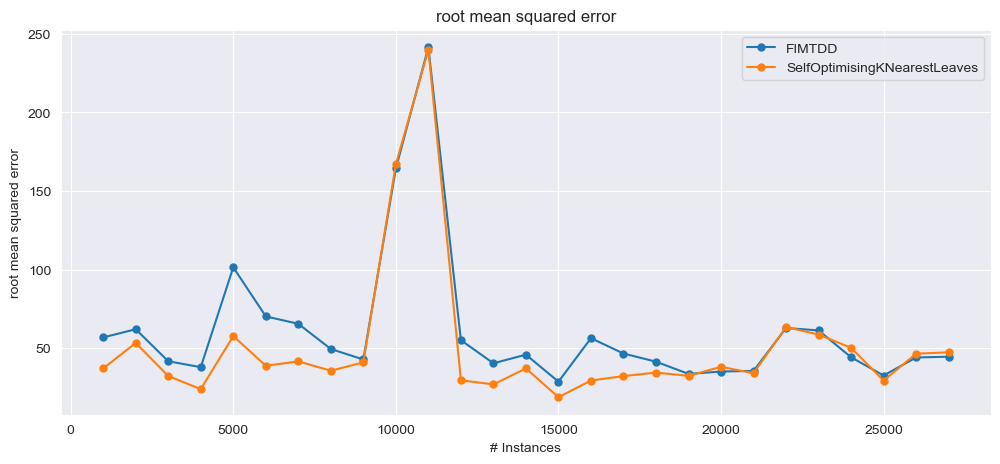

In [31]:
plot_windowed_results(fimtdd_results, soknl_results, metric='root mean squared error', save_only=False)

#### Plot real-time predictions, targets, and residuals

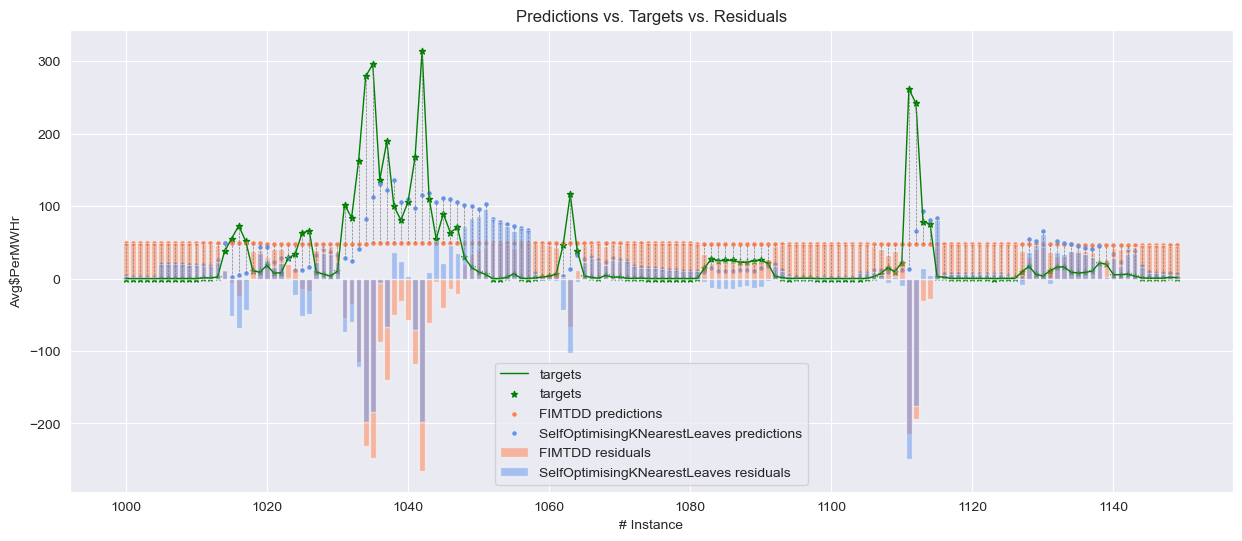

In [24]:
plot_regression_results(fimtdd_results, soknl_results, start=1000, end=1150, color_predictions=('coral','cornflowerblue'))

### Prediction Interval Example

In [15]:
mve = MVE(schema=example_stream.get_schema(), base_learner=SOKNL(schema=example_stream.get_schema(), ensemble_size=30))
adapi = AdaPI(schema=example_stream.get_schema(), base_learner=SOKNL(schema=example_stream.get_schema(), ensemble_size=30), limit=0.001)

mve_results = prequential_evaluation(stream=example_stream, learner=mve, window_size=1000, optimise=False, store_y=True, store_predictions=True)
adapi_results = prequential_evaluation(stream=example_stream, learner=adapi, window_size=1000, optimise=False, store_y=True, store_predictions=True)

print(f'MVE:\n Coverage: {mve_results["cumulative"].coverage()}\n NMPIW: {mve_results["cumulative"].NMPIW()}')
print(f'AdaPI:\n Coverage: {adapi_results["cumulative"].coverage()}\n NMPIW: {adapi_results["cumulative"].NMPIW()}')

MVE:
 Coverage: 97.07
 NMPIW: 6.53
AdaPI:
 Coverage: 97.02
 NMPIW: 6.25


#### Plot part of the prediction intervals

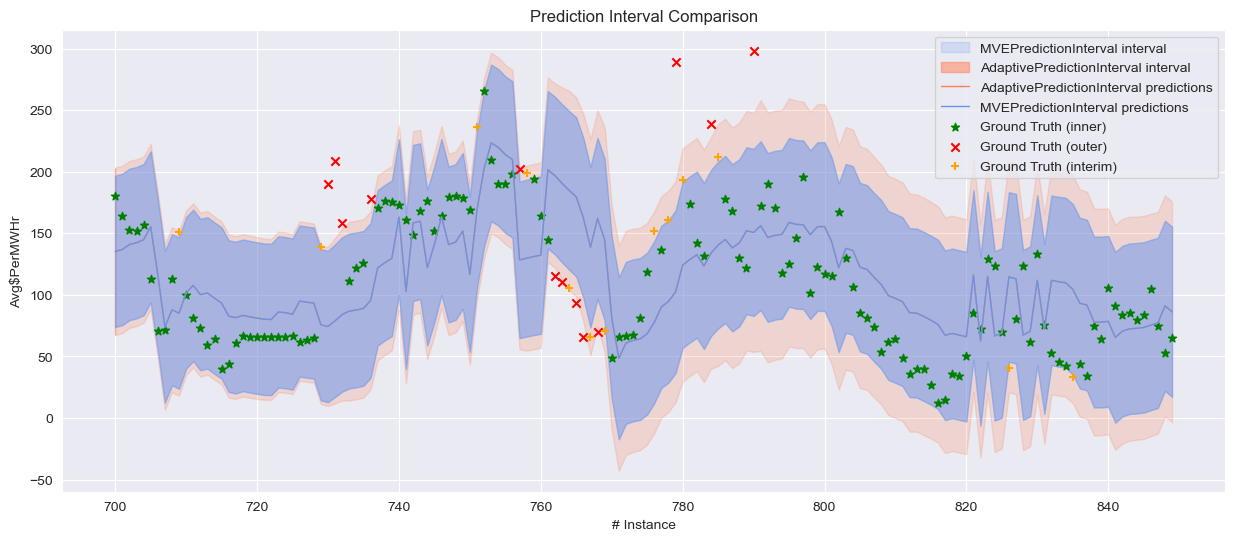

In [25]:
plot_prediction_interval(adapi_results, mve_results, start=700, end=850, colors=('coral','cornflowerblue'))

### Drift Analysis

In [26]:
from river import metrics, drift
from datetime import datetime, timedelta
import time

def check_list(x, reference, valid_types = [np.ndarray, list]):
    if type(reference[0]) in valid_types and type(x) not in valid_types:
            x = [x for n in reference]
    return x
    
def plot_values(axes, indices, values, drifts = None, colors = 'b', alpha = 1):
    indices = np.array(indices)
    values = np.array(values)
    axes = check_list(axes, values)
    colors = check_list(colors, values)
    alpha = check_list(alpha, values)
    lines = []
    for n in range(len(values)):
        ax = axes[n]
        line, = ax.plot(indices, values[n], color = colors[n], alpha = alpha[n])
        lines.append(line)
    return lines

def get_error(targets, predictions, metric = metrics.RMSE()):
    errors = []
    for target, pred in zip(targets, predictions):
        metric.update(target, pred)
        errors.append(metric.get())
    return errors

def get_drifts(drift_detector, data, indices = None):
    if indices == None:
        indices = range(len(data))

    drifts_found = []

    for d, i in zip(data, indices):
        drift_detector.update(d)
        if drift_detector.drift_detected:
            drifts_found.append(i)
    return drifts_found

In [27]:
def do_plot(ax, input, title, ylab = 'Error (MAE)', starting_date = datetime(2022, 11, 1),
            drift_detector_maker = lambda a: drift.PageHinkley(delta = 0.5)):

    dates = [starting_date + timedelta(hours=i/2) for i in range(len(input[0]))]
    
    lines = plot_values(ax, dates, input, colors = ['b', 'g'])

    drifts_detected = [get_drifts(drift_detector_maker(0), k_e, dates) for k_e in input]

    for i in range(2):
        noLine = True
        for d in drifts_detected[i]:
            l = ax.axvline(d, color=['r', 'purple'][i])
            if noLine:
                lines.append(l)
                noLine = False

    ax.set_xlabel('Date')
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.legend(lines, ['Average Dollars per MWHr for the Trading Period',
                'Median Dollars per MWHr for the Trading Period',
                'Drift for Average Dollars',
                'Drift for Median Dollars']
             )

[]

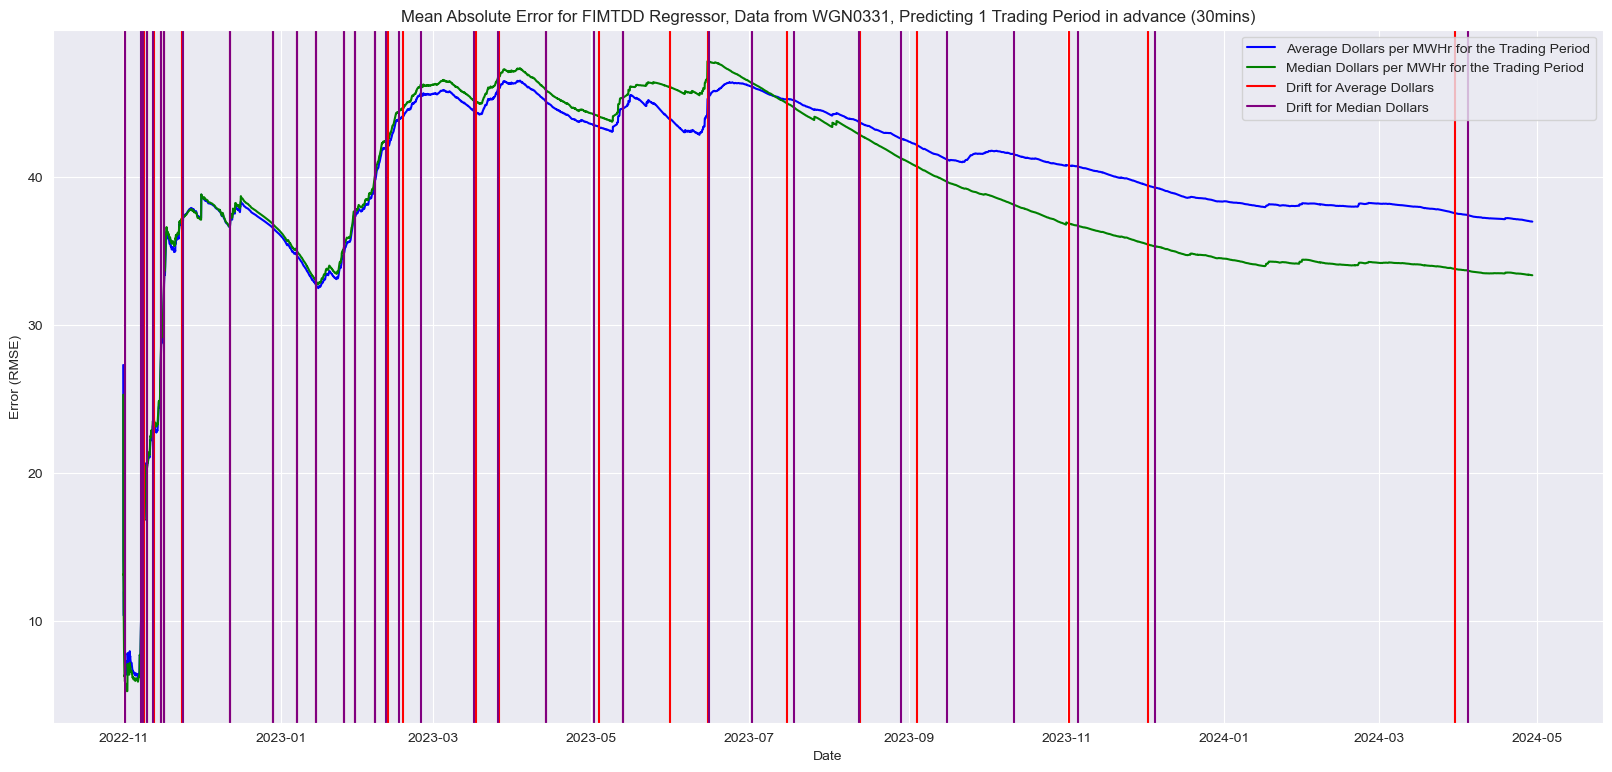

In [28]:
avg_stream = stream_from_file('./datasets/WGN0331/WGN0331_avg_0.5hr.arff')
med_stream = stream_from_file('./datasets/WGN0331/WGN0331_med_0.5hr.arff')

avg_results = prequential_evaluation(
    stream=avg_stream, learner=FIMTDD(schema=avg_stream.get_schema(), regression_tree=True), 
    window_size=1000, optimise=False, store_y=True, store_predictions=True
)
med_results = prequential_evaluation(
    stream=med_stream, learner=FIMTDD(schema=med_stream.get_schema(), regression_tree=True), 
    window_size=1000, optimise=False, store_y=True, store_predictions=True
)

fig, ax = pl.subplots(figsize = (20, 9))

base_error_30min_avg = get_error(avg_results['ground_truth_y'], avg_results['predictions'], metrics.MAE())
base_error_30min_med = get_error(med_results['ground_truth_y'], med_results['predictions'], metrics.MAE())
base_errors_30min = [base_error_30min_avg, base_error_30min_med]

do_plot(ax, base_errors_30min, 'Mean Absolute Error for FIMTDD Regressor, Data from WGN0331, Predicting 1 Trading Period in advance (30mins)')
pl.plot()

[]

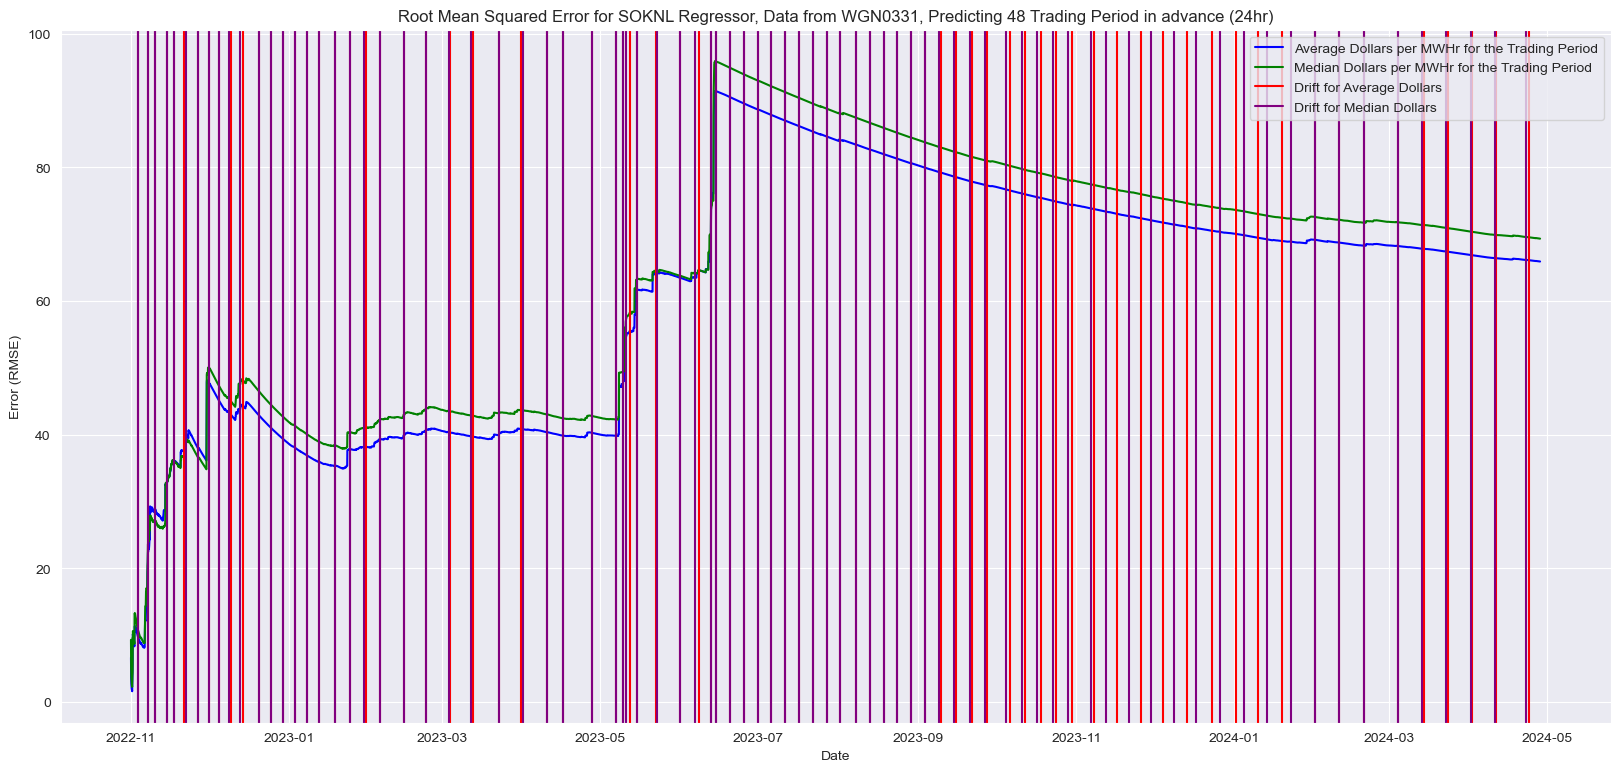

In [30]:
avg_stream = stream_from_file('./datasets/WGN0331/WGN0331_avg_24hr.arff')
med_stream = stream_from_file('./datasets/WGN0331/WGN0331_med_24hr.arff')

avg_results = prequential_evaluation(
    stream=avg_stream, learner=SOKNL(schema=avg_stream.get_schema()), 
    window_size=1000, optimise=False, store_y=True, store_predictions=True
)
med_results = prequential_evaluation(
    stream=med_stream, learner=SOKNL(schema=med_stream.get_schema()), 
    window_size=1000, optimise=False, store_y=True, store_predictions=True
)

fig, ax = pl.subplots(figsize = (20, 9))

base_error_24hr_avg = get_error(avg_results['ground_truth_y'], avg_results['predictions'], metrics.RMSE())
base_error_24hr_med = get_error(med_results['ground_truth_y'], med_results['predictions'], metrics.RMSE())
base_errors_24hr = [base_error_24hr_avg, base_error_24hr_med]

do_plot(ax, base_errors_24hr, 'Root Mean Squared Error for SOKNL Regressor, Data from WGN0331, Predicting 48 Trading Period in advance (24hr)',
       drift_detector_maker = lambda a: drift.ADWIN(delta = 10**-6))
pl.plot()